<a href="https://colab.research.google.com/github/GodfreyAchu/Diabetic-Retinopathy/blob/main/Diabeticretinopathy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image

import tensorflow as tf
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.metrics import confusion_matrix

print("All modules have been imported")

All modules have been imported


In [ ]:
info=pd.read_csv("/content/train_1.csv")
info.head()

id_code  diagnosis
0  a00b4cb250a7          1
1  a01024054596          1
2  a015ce4f51ad          2
3  a01c590c444f          2
4  a0267206d51e          2

In [ ]:
info.diagnosis.value_counts()

0    358
2    197
1     79
4     51
3     37
Name: diagnosis, dtype: int64

<Axes: ylabel='diagnosis'>

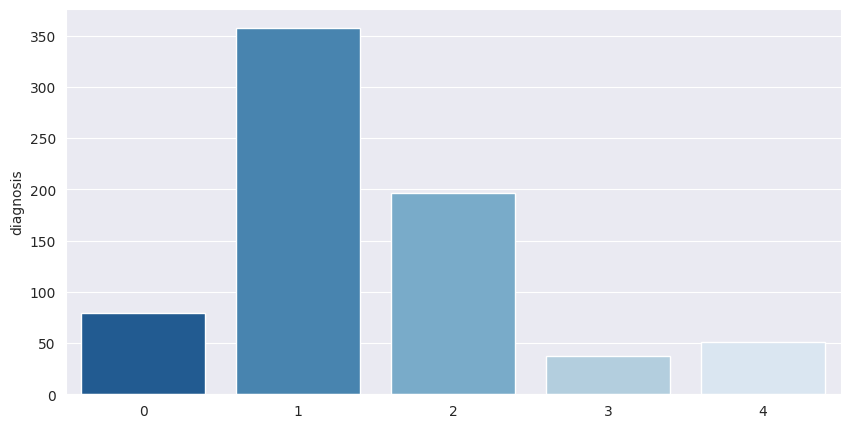

In [ ]:
import seaborn as sns
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x=info.diagnosis.unique(),y=info.diagnosis.value_counts(),palette='Blues_r',ax=ax)

<ipython-input-6-34ede2e6794e>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sizes, kde=False)


<Axes: >

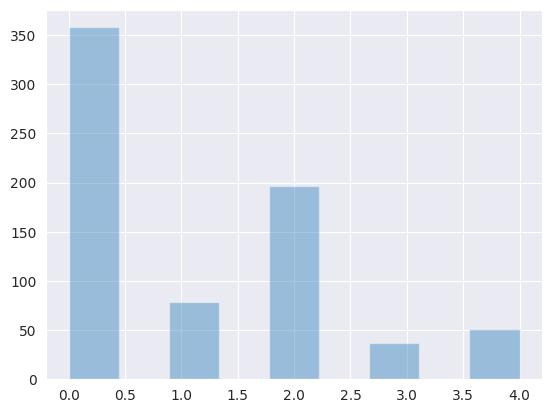

In [ ]:
sizes = info['diagnosis'].values
sns.distplot(sizes, kde=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("drive/My Drive/Project")

In [ ]:
!ls

test_1	train_1


In [ ]:
def load_data():
    train = pd.read_csv('/content/train_1.csv')
    test = pd.read_csv('/content/test.csv')

    train_dir = os.path.join('/content/drive/MyDrive/Project/train_1')
    test_dir = os.path.join('/content/drive/MyDrive/Project/test_1')

    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir,'{}.png'.format(x)))

    train['file_name'] = train["id_code"].apply(lambda x: x + ".png")
    test['file_name'] = test["id_code"].apply(lambda x: x + ".png")

    train['diagnosis'] = train['diagnosis'].astype(str)

    return train,test

In [ ]:
df_train,df_test = load_data()
print(df_train.shape,df_test.shape,'\n')
df_train.head(6)

(722, 4) (1928, 3) 



id_code diagnosis                                          file_path  \
0  a00b4cb250a7         1  /content/drive/MyDrive/Project/train_1/a00b4cb...   
1  a01024054596         1  /content/drive/MyDrive/Project/train_1/a010240...   
2  a015ce4f51ad         2  /content/drive/MyDrive/Project/train_1/a015ce4...   
3  a01c590c444f         2  /content/drive/MyDrive/Project/train_1/a01c590...   
4  a0267206d51e         2  /content/drive/MyDrive/Project/train_1/a026720...   
5  a02dfd67a925         0  /content/drive/MyDrive/Project/train_1/a02dfd6...   

          file_name  
0  a00b4cb250a7.png  
1  a01024054596.png  
2  a015ce4f51ad.png  
3  a01c590c444f.png  
4  a0267206d51e.png  
5  a02dfd67a925.png

In [ ]:
def plot_classes(df):
    df_group = pd.DataFrame(df.groupby('diagnosis').agg('size').reset_index())
    df_group.columns = ['diagnosis','count']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot(x = 'diagnosis',y='count',data = df_group,palette = "Blues_d")
    plt.title('Output Class Distribution')
    plt.show()

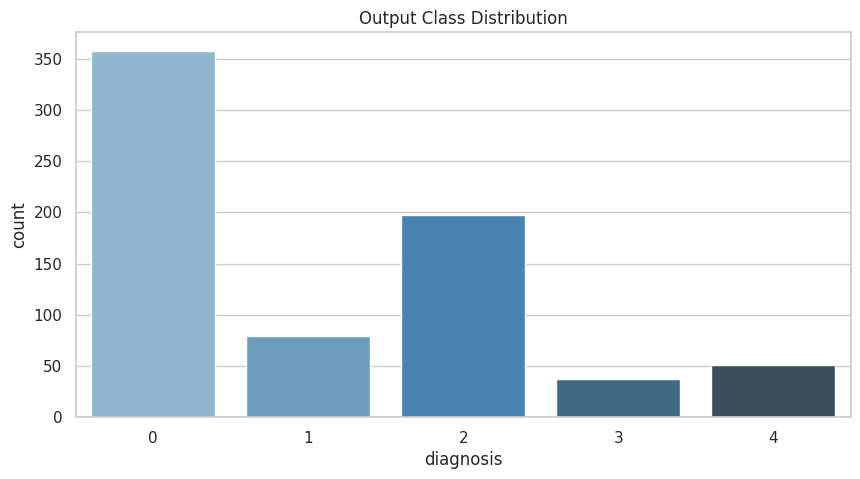

In [ ]:
plot_classes(df_train)

In [ ]:
IMG_SIZE = 200

In [ ]:
def conv_gray(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    return img


'''
This Function shows the visual Image photo of 'n x 5' points (5 of each class)
'''

def visualize_imgs(df,pts_per_class,color_scale):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)

    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")

        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            if color_scale == 'gray':
                img = conv_gray(cv2.imread(df_temp.file_path.iloc[i]))
                axarr[i].imshow(img,cmap = color_scale)
            else:
                axarr[i].imshow(Image.open(df_temp.file_path.iloc[i]).resize((IMG_SIZE,IMG_SIZE)))
            axarr[i].set_xlabel(''+str(df_temp.diagnosis.iloc[i]))

        plt.show()

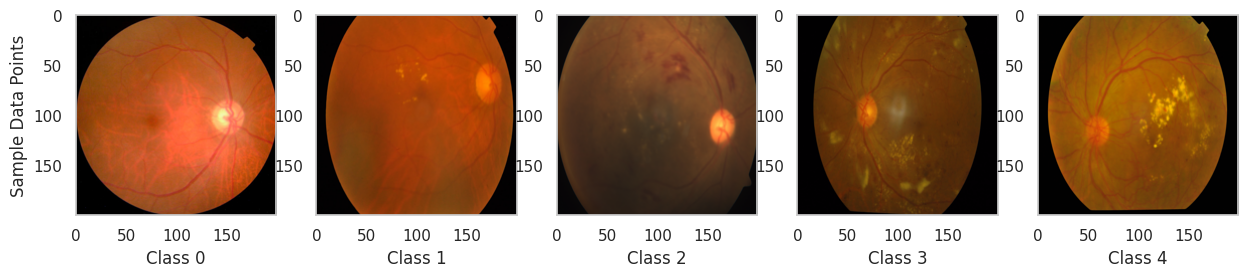

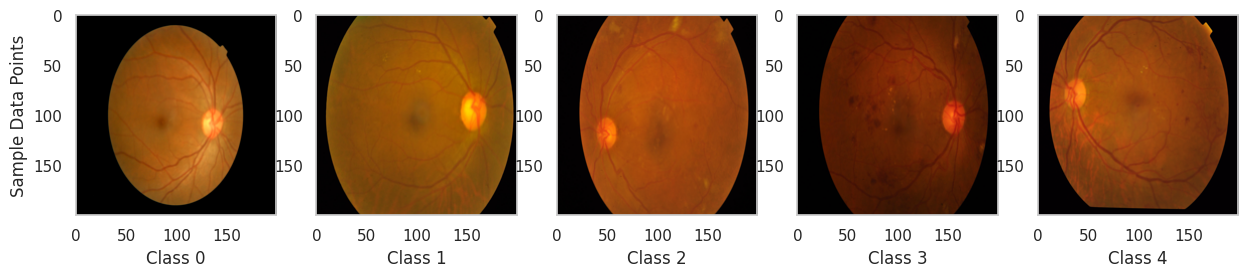

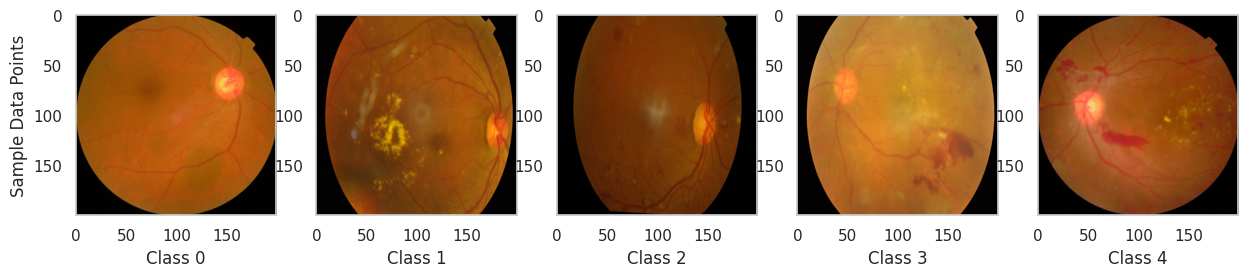

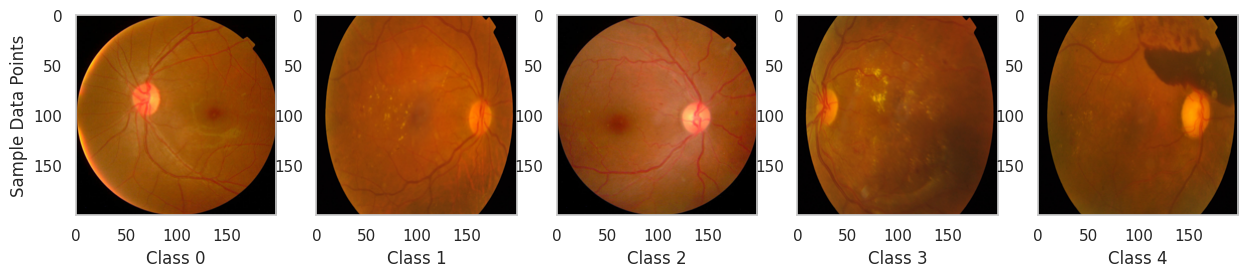

In [ ]:
visualize_imgs(df_train,4,color_scale = None)

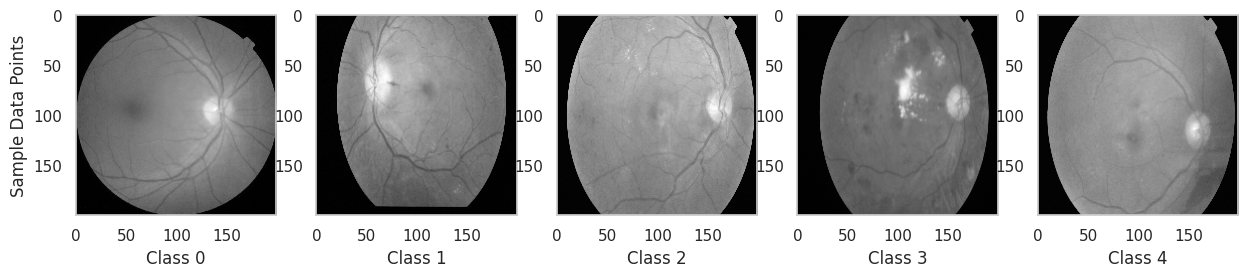

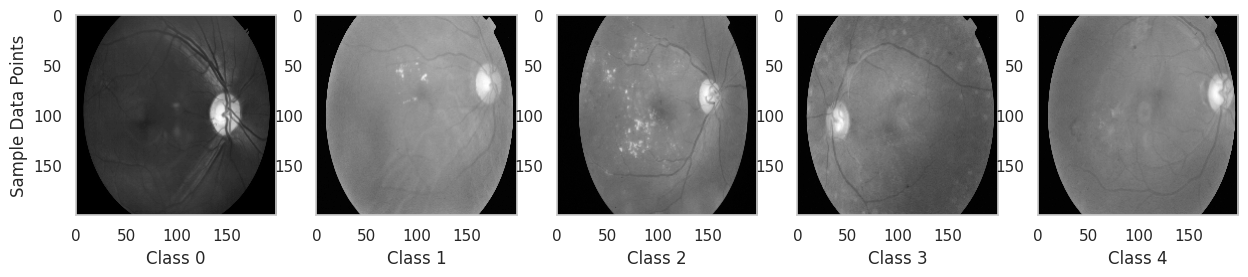

In [ ]:
visualize_imgs(df_train,2,color_scale = 'gray')

Gaussian Blur

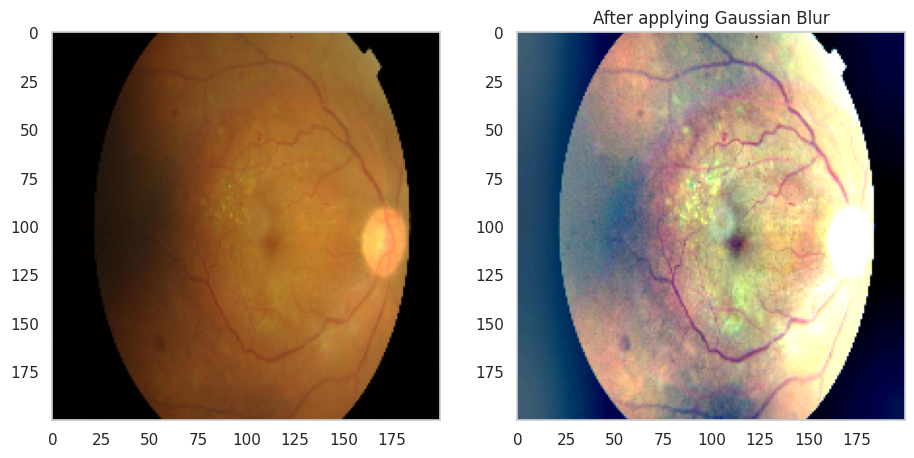

In [ ]:
rn = np.random.randint(low = 0,high = len(df_train) - 1)

img = cv2.imread(df_train.file_path.iloc[rn])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

img_t = cv2.addWeighted(img,4, cv2.GaussianBlur(img , (0,0) , 30) ,-4 ,128)

f, axarr = plt.subplots(1,2,figsize = (11,11))
axarr[0].imshow(img)
axarr[1].imshow(img_t)
plt.title('After applying Gaussian Blur')
plt.show()

Gaussian Blur with Circular Cropping

In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img


def circle_crop(img, sigmaX):
    """
    Create circular crop around image centre
    """
    img = crop_image_from_gray(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    height, width, depth = img.shape

    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img

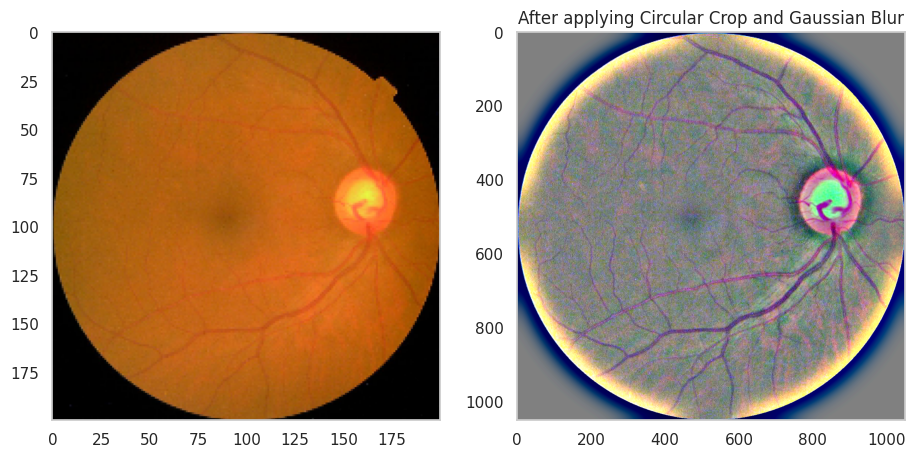

In [ ]:
rn = np.random.randint(low = 0,high = len(df_train) - 1)

#img = img_t
img = cv2.imread(df_train.file_path.iloc[rn])
img_t = circle_crop(img,sigmaX = 30)

f, axarr = plt.subplots(1,2,figsize = (11,11))
axarr[0].imshow(cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),(IMG_SIZE,IMG_SIZE)))
axarr[1].imshow(img_t)
plt.title('After applying Circular Crop and Gaussian Blur')
plt.show()

Visualizations Summary - Clearly we understand the importance of performing image processing operations here. We have performed Gaussian Blur to bring out the image details and features much more clearly and explicitly.

In [ ]:
def visualize_img_process(df,pts_per_class,sigmaX):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)

    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")

        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            img = cv2.imread(df_temp.file_path.iloc[i])
            img = circle_crop(img,sigmaX)
            axarr[i].imshow(img)
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

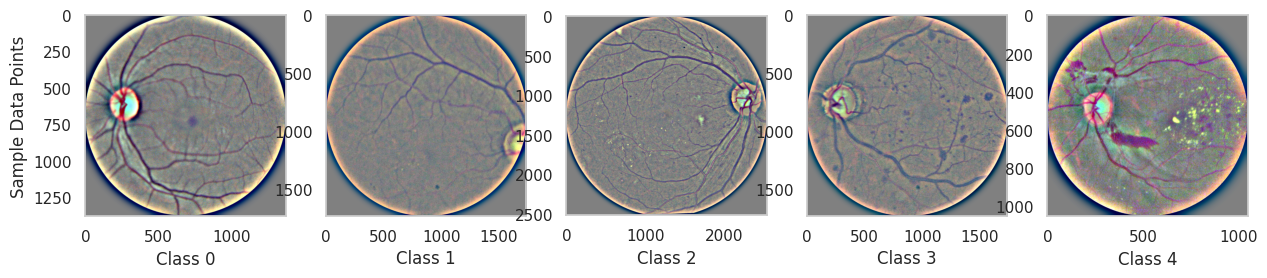

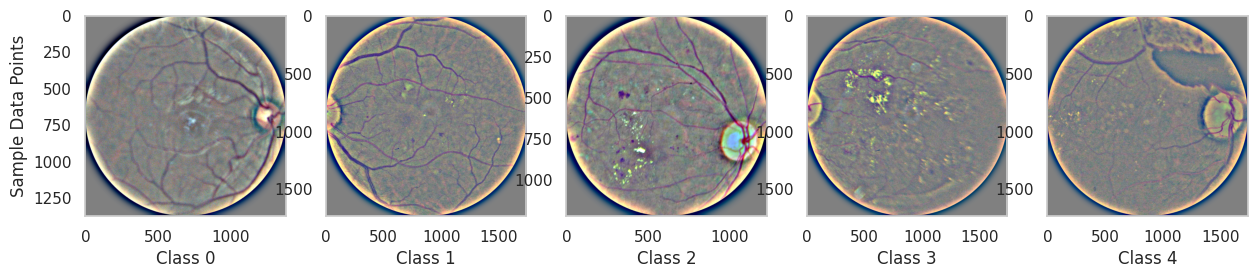

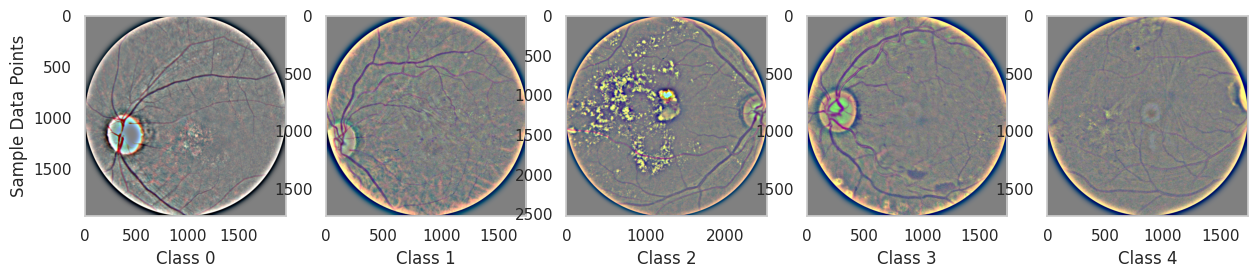

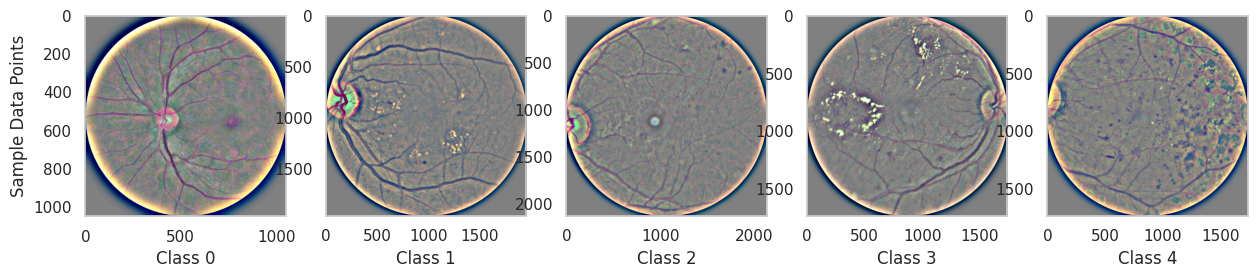

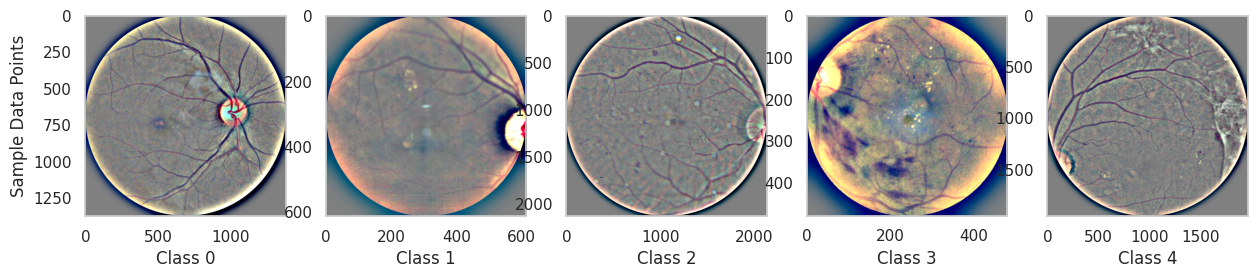

In [ ]:
visualize_img_process(df_train,5,sigmaX = 30)


Image Argumentation.

In [ ]:
def generate_augmentations(lim):
    datagen = ImageDataGenerator(featurewise_center=True,
                                 featurewise_std_normalization=True,
                                 rotation_range=20,
                                 #width_shift_range=0.2,
                                 #height_shift_range=0.2,
                                 horizontal_flip=True)
    img = cv2.imread(df_train.file_path.iloc[np.random.randint(low = 0,high = len(df_train) - 1)])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.title('ORIGINAL IMAGE')
    plt.show()

    img_arr = img.reshape((1,) + img.shape)

    i = 0
    for img_iterator in datagen.flow(x = img_arr,batch_size = 1):
        i = i + 1
        if i > lim:
            break
        plt.imshow((img_iterator.reshape(img_arr[0].shape)).astype(np.uint8))
        plt.title('IMAGE AUGMENTATION ' + str(i))
        plt.show()

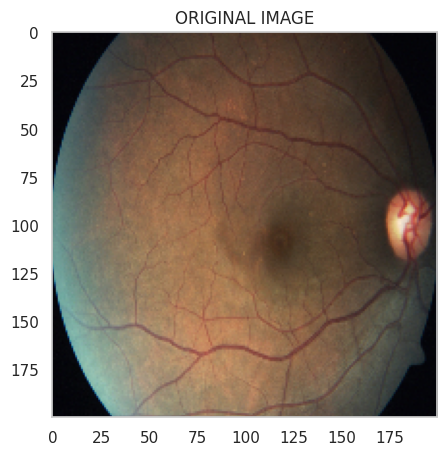

/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1871: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


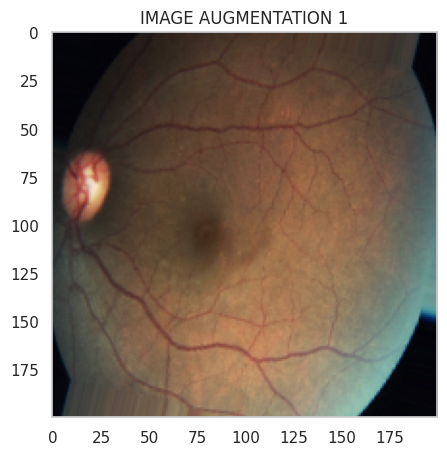

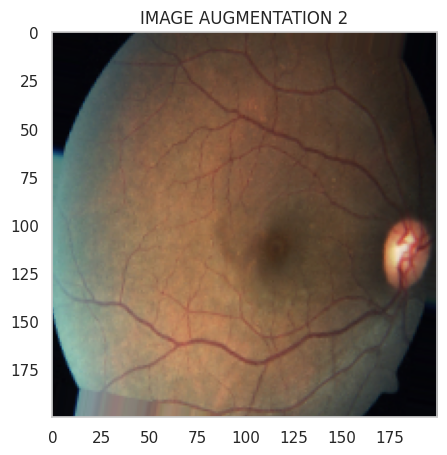

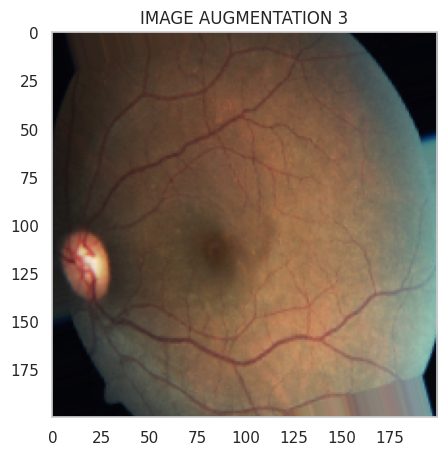

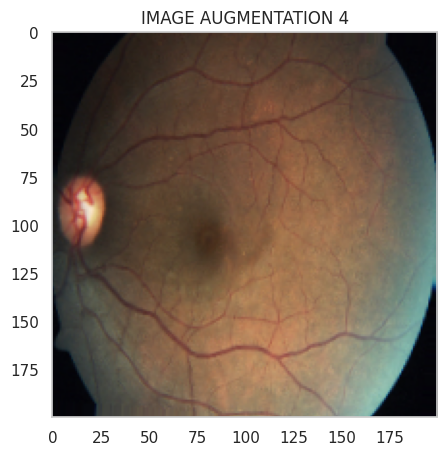

In [ ]:
generate_augmentations(4)

Summary - As we can see above, Image Augmentations are extremely helpful for this data to make our Models more Robust and would also have a higher ability to generalize well